In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import os
import wandb
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

In [22]:
import numpy as np
import pandas as pd
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

class ParticipantVisibleError(Exception):
    pass


def pAUC(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)

In [3]:
run = wandb.init(project="isic_lesions_24")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ayush-thakur. Use `wandb login --relogin` to force relogin


In [4]:
train_metadata_df = pd.read_csv("../data/train-metadata.csv")

/tmp/ipykernel_581916/2139135023.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata_df = pd.read_csv("../data/train-metadata.csv")


In [70]:
columns = [
    'tbp_lv_areaMM2', # Area of lesion (mm^2).
    'tbp_lv_perimeterMM', # Perimeter of lesion (mm)
    'tbp_lv_minorAxisMM', # Smallest lesion diameter (mm)
    'clin_size_long_diam_mm', # Maximum diameter of the lesion (mm)
    'tbp_lv_stdLExt', # Standard deviation of L outside lesion.
    'tbp_lv_radial_color_std_max', # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion
    'tbp_lv_color_std_mean', # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_Aext', # ?
    'tbp_lv_norm_color', # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity
    'tbp_lv_B', # B inside lesion
    'tbp_lv_Hext', # Hue outside lesion.
    'tbp_lv_deltaB', # Average B contrast (inside vs. outside lesion)
    'tbp_lv_H', # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space
    # 'tbp_lv_dnn_lesion_confidence' # Lesion confidence score (0-100 scale) (only in train - can train a classifier for test time confidence calculation)
]

In [71]:
X = train_metadata_df[['isic_id']+columns]
y = train_metadata_df[['isic_id', 'target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y['target'])

In [72]:
model = LogisticRegression(max_iter=2000, class_weight='balanced')

model.fit(X_train[columns], y_train['target'])

LogisticRegression(class_weight='balanced', max_iter=2000)

Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     80133
           1       0.00      0.80      0.01        79

    accuracy                           0.83     80212
   macro avg       0.50      0.81      0.46     80212
weighted avg       1.00      0.83      0.91     80212

Confusion Matrix:
[[66581 13552]
 [   16    63]]


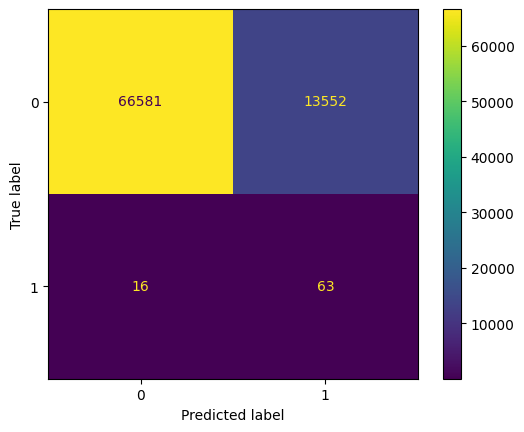

In [73]:
y_pred = model.predict(X_test[columns])

# Evaluate the model
accuracy = accuracy_score(y_test['target'], y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test['target'], y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test['target'], y_pred))
cm = confusion_matrix(y_test['target'], y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [82]:
y_pred_proba = model.predict_proba(X_test[columns])[:, 1]

submission_df = pd.DataFrame(columns=["isic_id", "preds"], data=list(zip(X_test['isic_id'].values, y_pred_proba)))

In [78]:
gt = copy.deepcopy(y_test)
preds = copy.deepcopy(submission_df)

partial_auc = pAUC(gt, preds, row_id_column_name='isic_id')
partial_auc

0.12636605567295003

In [83]:
import joblib

model_filename = '../models/trained_classifier.joblib'
joblib.dump(model, model_filename)

['../models/trained_classifier.joblib']

### LightGBM based clf

In [84]:
import lightgbm as lgb

In [86]:
lgb_train = lgb.Dataset(X_train[columns], label=y_train['target'])
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}
clf = lgb.train(params, lgb_train, num_boost_round=1000)


[LightGBM] [Info] Number of positive: 314, number of negative: 320533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 320847, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000979 -> initscore=-6.928348
[LightGBM] [Info] Start training from score -6.928348


In [89]:
y_pred

array([1.20843617e-04, 1.92055162e-05, 4.09099206e-15, ...,
       2.73433232e-05, 3.19298273e-86, 3.98340566e-06])

In [90]:
y_pred_proba = clf.predict(X_test[columns])

submission_df = pd.DataFrame(columns=["isic_id", "preds"], data=list(zip(X_test['isic_id'].values, y_pred_proba)))

gt = copy.deepcopy(y_test)
preds = copy.deepcopy(submission_df)

partial_auc = pAUC(gt, preds, row_id_column_name='isic_id')
partial_auc

0.06446851729253278

In [100]:
df_imp = pd.DataFrame({"feature": clf.feature_name(), "importance": clf.feature_importance()}).sort_values("importance").reset_index(drop=True)

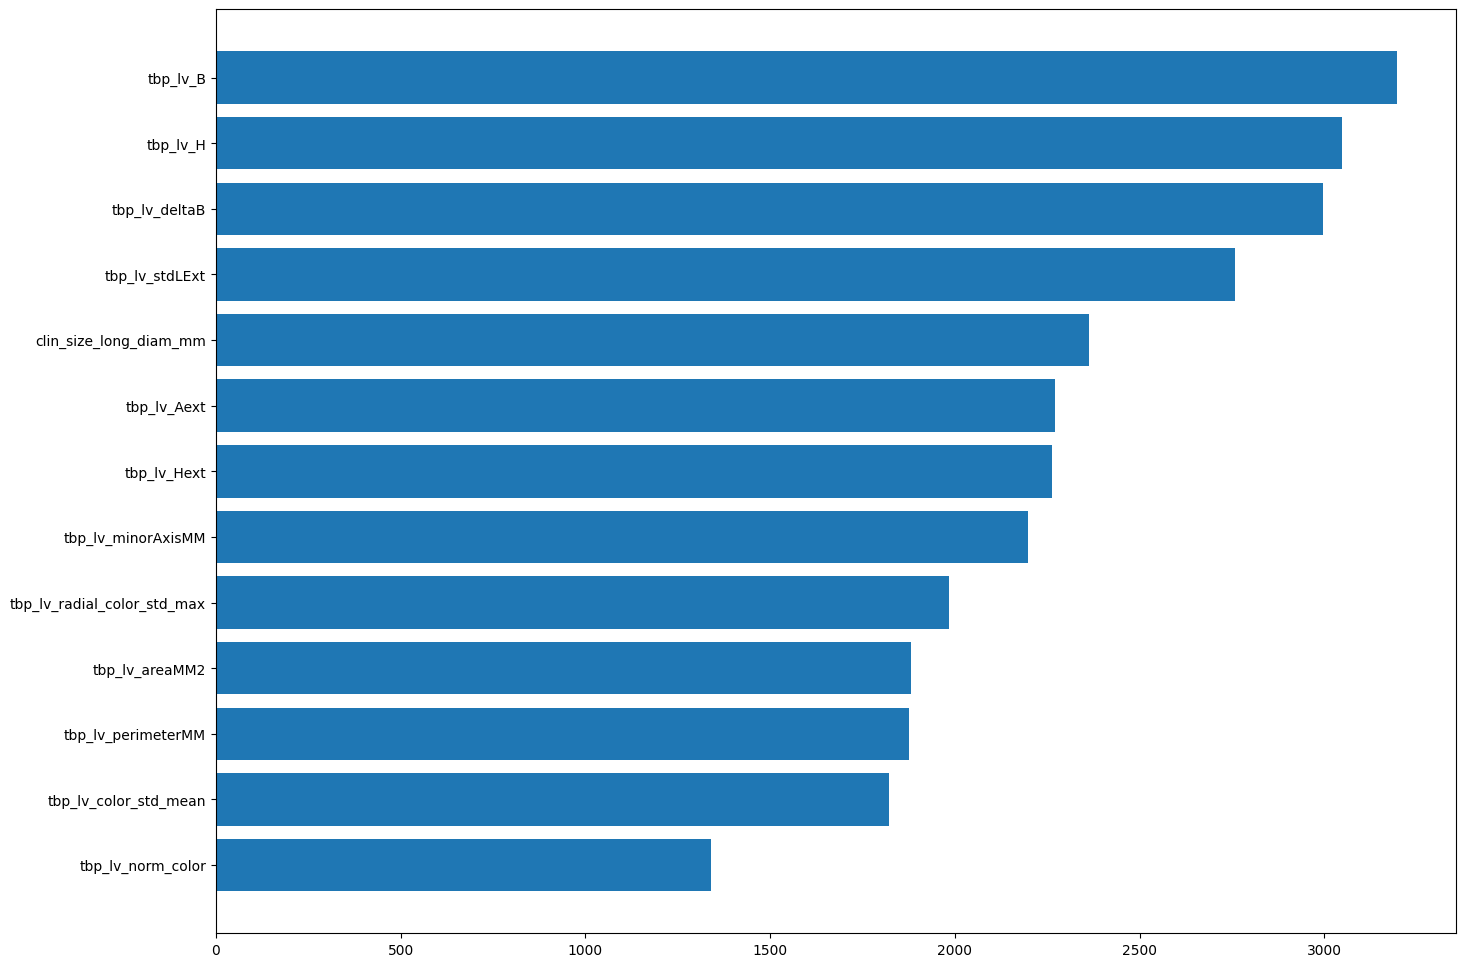

In [101]:
plt.figure(figsize=(16, 12))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()